# Práctica: Algoritmo Genético

## Introducción al concepto

Los algoritmos genéticos se inspiran en la evolución biológica y su base genético-molecular. La idea base del algoritmo es hacer evolucionar una población de individuos sometiéndola a acciones aleatorias similares a las que actuan en la evolución biológica (mutaciones y recombinaciones genéticas) así también como la selección de acuerdo a algún criterio.

## Esquema

El algoritmo genético puede variar en función de:
* Aplicación de los operadores genéticos
* Proceso de selección
* Tipo de reemplazo de los individuos (para nueva población)

El esquema que sigue dicho algoritmo es el siguiente:
* Inicialización: Se generan una población inicial de tamaño N de forma aleatoria que representa un conjunto de soluciones potenciales al problema.
* Evaluación: Se aplica una función para calcular la bondad de cada una de las soluciones (métrica de rendimiento) que permitirá posteriormente comparar.
* Selección: Se escogen 2 soluciones del conjunto, mediante algún tipo de criterio (pueden usarse diversos, de forma paralela).
* Cruce de soluciones: Mediante métodos de recombinación o mutuación se obtienen nuevas soluciones generadas a partir de los conjuntos de pares seleccionados. Para ello es necesario realizar $\frac{Num.configuraciones}{2}$ pasadas tomando conjuntos de 2 padres cada vez.

A continuación se presenta de forma visual el esquema detallado anteriormente:
![Esquema](esquema.png)

## Implementación - Librerias necesarias

In [1]:
%matplotlib inline
import random
import numpy as np
import json
import time
import pandas as pd
import itertools
import sys

# Implementación  - Conjunto de datos

## Conjunto simulado

In [43]:
def gen_pymachine(pmid):
    pm = {
        "cores": random.randint(1,4),
        "id": pmid,
        "mainmemory": random.randint(10000,20000),
        "powermax": random.randint(1000,3000),
        "powermin": random.randint(300, 700),
        "vmwareoverhead": random.random()/10
    }
    return pm

def gen_vmachine(vmid):
    vm = {
        "cpuusage": random.randint(1, 100)/100,
        "id": vmid,
        "mainmemory": random.randint(350,1000)
    }
    return vm

pmconfs = [gen_pymachine(i) for i in range(0, 400)]
vmconfs = [gen_vmachine(i) for i in range(0, 1000)]
cpu = np.array([vm["cpuusage"] for vm in vmconfs])
mem = np.array([vm["mainmemory"] for vm in vmconfs])

## Conjunto origen

In [2]:
data = json.load(open('definition.json'))
pmconfs = data["PM"]
vmconfs = data["VM"]
cpu = np.array([vm["cpuusage"] for vm in vmconfs])
mem = np.array([vm["mainmemory"] for vm in vmconfs])

In [86]:
data = json.load(open('testfile3.json'))
pmconfs = data["PM"]
vmconfs = data["VM"]
cpu = np.array([vm["cpuusage"] for vm in vmconfs])
mem = np.array([vm["mainmemory"] for vm in vmconfs])

In [87]:
len(pmconfs)

20

In [88]:
len(vmconfs)

38

In [27]:
cpu

1350

In [11]:
mem

array([125, 125, 500, 250, 250, 750, 500])

## Implementación - Algoritmos de simulación

In [67]:
def solutions_simulation(pmconfs, nconfs, nvm, npm, cpu_usage, mem_usage):
    """ Method that generates a random solutions set and 
        then gets consumption for each solution """
    vmconfs = vmconf_generation(nconfs, nvm, npm)
    solutions_comp = compute_solutions(pmconfs, vmconfs, cpu_usage, mem_usage)
    return [vmconfs, solutions_comp]

def compute_solutions(pmconfs, vmconfs, cpu_usage, mem_usage):
    """ Method that get results for each configuration with 
        restrictions of cpu and memory usage """

    # Dictionary with all data configuration (if it is posible)
    conftot = {}
    
    # For each configuration obtains data
    for conf in vmconfs.items():
        
        # List with idx for each physical machine (configuration i)
        confidx = get_pmidxs(conf[1], len(pmconfs))
        
        # Create confi summary
        conftot.update(get_results_confi(conf[0], pmconfs, 
                                         confidx, cpu_usage, 
                                         mem_usage))
    
    # Getting total consumption by configuration
    conficons = [get_consumption_confi(confi) for confi in conftot.values()]
    
    return conficons

def get_pmidxs(confi, npm):
    """Given a virtual machines distribution, 
       returns idx for each physical machine"""
    confidx = []
    for pmid in range(0, npm):
        confidx.append([idx for idx,x in enumerate(confi) if x == pmid])
    return confidx

def get_results_confi(key, pmconfs, confidx, cpu_usage, mem_usage):
    """ Returns summary of provided configuration """
    confi = {key: {}}
    pmidx = 0
    #no_valid_cons = (pmconfs[0]["powermax"] * pmconfs[1]["powermax"] * 
    #                 pmconfs[2]["powermax"] * pmconfs[3]["powermax"])**10
    no_valid_cons = 999999999
    for pmids in confidx:
          
        if pmids:   
            # Get configuration of machine i
            pmconfi = pmconfs[pmidx]

            # Get total cpu consumption
            tcpu = sum(cpu_usage[pmids]) + pmconfi["vmwareoverhead"]

            # Get total mem consumption
            tmem = sum(mem_usage[pmids])

            # Get total mem provided
            limmem = pmconfi["mainmemory"]

            # Get total cpu provided
            limcpu = pmconfi["cores"]

            # If mem consumption is lower (is posible)
            if tcpu <= limcpu and tmem <= limmem:
                confi[key].update({"pm{}-{}".format(pmidx,key): {
                    "cpu": tcpu,
                    "mem": tmem,
                    "watt": cpu_watt(tcpu/limcpu , pmconfi["powermin"], pmconfi["powermax"])
                }})
            # Configuration is not posible
            else:
                confi[key].update({"pm{}-{}".format(pmidx,key): {
                    "cpu": tcpu,
                    "mem": tmem,
                    "watt": no_valid_cons
                }})
                break
        pmidx += 1
    
    return confi

def get_consumption_confi(confi_cons):
    """ Get consumption of configuration i """
    if confi_cons != None:
        tconsumption = 0
        for pmconfi in confi_cons.values():
            tconsumption += pmconfi["watt"]
        return tconsumption
    else:
        return None
    
def cpu_watt(cpu_use, widle, wmax):
    """ Returns the theoretical consumption value of CPU """
    return widle + ((cpu_use) * (wmax - widle))

def vmconf_generation(nconfs, nvm, npm):
    """Given number of configurations, 
             number of virtual machines
             number of physical machines.
        Returns dictionary with n random
        generated configurations"""
    confs = {}
    for i in range(0, nconfs):
        # Configuration i
        confi = [random.randint(0,npm-1) for j in range(0, nvm)]
        confs.update({"conf{}".format(i): confi})
    return confs

## Implementación - Algoritmo genético

In [119]:
def recombination(confs, nconsumptions, nvm):
    """ Given a configurations set, recombine the best random
        selected parents to generate new childs. Returns a new
        sample of size nconfs"""
    nconfs = len(confs)
    childs = {}
    
    for i in range(0, int(nconfs/2)):
    
        # Get cut point of parent sample
        cut_point = random.randint(0, nvm - 1)

        # Take parents from sample
        parents = get_tournament(nconsumptions)
        #parents = get_tournament_prob(nconsumptions)
                
        # Taking configurations
        confp1 = confs["conf{}".format(parents[0])]
        confp2 = confs["conf{}".format(parents[1])]

        # Generating new childs with a random cut_off
        child1 = confp1[:cut_point] + confp2[cut_point:]
        child2 = confp1[cut_point:] + confp2[:cut_point]
        
        # Adding new childs to set
        childs.update({"conf{}".format(i*2): child1})
        childs.update({"conf{}".format(i*2+1): child2})
    
    return childs
    
def get_tournament(solutions_cons_set):
    """ Take 2 random configurations and take the best """
    nsample = 2
    nrounds = 2
    size_set = len(solutions_cons_set)
    
    # List with idx with best configuration
    max_idx = []
    # Generate N rounds
    for i in range(0, nrounds):
        # Take 2 random configurations
        ranidx = [random.randint(0, size_set - 1) for i in range(0, nsample)]
        # Take index of best conf
        if solutions_cons_set[ranidx[0]] > solutions_cons_set[ranidx[1]]:
            max_idx = max_idx.__iadd__([ranidx[0]])
        else:
            max_idx = max_idx.__iadd__([ranidx[1]])
    
    return max_idx

def get_tournament_prob(solutions_cons_set):
    """Given solutions consumption, returns two 
    random mins by probability. The lower values has 
    more probability"""
    tot_cons = sum(solutions_cons_set)
    sort_solutions = np.array(sorted(solutions_cons_set))
    prop_cons = list(reversed([consi/tot_cons for consi in sort_solutions]))
    min_elems = list(np.random.choice(solutions_cons_set, 2, p=prop_cons))
    max_idx = [np.where(sort_solutions == min_elems[0])[0][0],
               np.where(sort_solutions == min_elems[1])[0][0]]
    return max_idx

def get_best_confs(nconfs, ncons, nconfs_rec, ncons_rec):
    
    # We take the nconfs better of total (nconfs * 2) tipically
    nconfs_complete = list(nconfs.values()) + list(nconfs_rec.values())
    ncons_complete = list(ncons) + list(ncons_rec)
        
    best_idx = sorted(range(len(ncons_complete)), 
                    key=lambda i: ncons_complete[i])[:len(nconfs)]
        
    nconfs_complete = np.array(nconfs_complete)[best_idx]
    ncons_complete = np.array(ncons_complete)[best_idx]
        
    confs = {}
    i = 0
    # Conver confs to format
    for conf in nconfs_complete:
        confs.update({"conf{}".format(i): list(conf)})
        i+=1
        
    return confs, ncons_complete
    
def mutate_population(nconfs, npm):
    """"""
    for idx in range(0, len(nconfs)):
        idconf = "conf{}".format(idx)
        nconfs.update({idconf: mutate_individual(nconfs[idconf], npm)})
        
    return nconfs

def mutate_individual(nconf, npm):
    """"""
    max_mutations = len(nconf)
    nmutations = random.randint(1, max_mutations)
    idx_individuals = np.array(random.sample(range(0,len(nconf)), nmutations))
    for idx in idx_individuals:
        nconf[idx] = random.randint(0, npm-1)
    
    return nconf

def genetic_algorithm_complete(pmconfs, nconfs, nvm, cpu_usage, mem_usage):
    """ Produce new samples given a parents set and take the lower consumption
        of the best population selected between parents and childs"""
    
    nochanges = 0
    niter = 0
    maxattemps = 2000

    # Number of physical machines
    npm = len(pmconfs)
    
    # Generate a start sample
    nconfs, ncons = solutions_simulation(pmconfs, nconfs, nvm, npm, cpu_usage, mem_usage)

    # Condition variables (Base case)
    minval = min(ncons)
    curr_min = minval
    idx_best = [idx for idx,x in enumerate(ncons) if x == curr_min]
    conf_opt = [list(nconfs.values())[idx] for idx in idx_best]
    
    while True:
        
        # Recombine 
        nconfs_rec = recombination(nconfs, ncons, nvm)
        
        # Applying mutations to childs set
        nconfs_rec = mutate_population(nconfs_rec, npm)
        
        # Getting childs consumption
        ncons_rec = compute_solutions(pmconfs, nconfs_rec, cpu_usage, mem_usage)
        
        # Taking best nconfs (between parents and childs)
        nconfs, ncons = get_best_confs(nconfs, ncons, nconfs_rec, ncons_rec)
        
        # Take minimum value
        curr_min = min(ncons)
        #print("MIN: ", curr_min)
        
        # Check if there is a new minimum
        if curr_min < minval:
            print("NEW: ", curr_min)
            minval = curr_min
            idx_best = [idx for idx,x in enumerate(ncons) if x == curr_min]
            conf_opt = [list(nconfs.values())[idx] for idx in idx_best]
            nochanges = 0
        else:
            nochanges+=1
            if nochanges == maxattemps:
                niter += 1
                break
        niter += 1
        
    return [minval, conf_opt, niter-maxattemps]
    
def genetic_algorithm_alternative(pmconfs, nconfs, nvm, cpu_usage, mem_usage):    
    """ Produce new samples given a parents set and take the lower consumption
        of the best population selected between parents and childs"""
    
    nochanges = 0
    niter = 0
    maxattemps = 50
    
    # Number of physical machines
    npm = len(pmconfs)
    
    # Generate a start sample
    nconfs, ncons = solutions_simulation(pmconfs, nconfs, nvm, npm, cpu_usage, mem_usage)
    
    # Condition variables (Base case)
    minval = min(ncons)
    curr_min = minval
    idx_best = [idx for idx,x in enumerate(ncons) if x == curr_min]
    conf_opt = [list(nconfs.values())[idx] for idx in idx_best]
    
    while True:
        
        # Recombine 
        nconfs = recombination(nconfs, ncons, nvm)
        
        # Applying mutations to childs set
        nconfs = mutate_population(nconfs, npm)
        
        # Getting childs consumption
        ncons = compute_solutions(pmconfs, nconfs, cpu_usage, mem_usage)
        
        # Taking best nconfs (between parents and childs)
        #nconfs, ncons = get_best_confs(nconfs, ncons, nconfs_rec, ncons_rec)
        
        # Take minimum value
        curr_min = min(ncons)
        
        # Check if there is a new minimum
        if curr_min < minval:
            minval = curr_min
            idx_best = [idx for idx,x in enumerate(ncons) if x == curr_min]
            conf_opt = [list(nconfs.values())[idx] for idx in idx_best]
            nochanges = 0
        else:
            nochanges+=1
            if nochanges == maxattemps:
                niter += 1
                break
        niter += 1
        
    return [minval, conf_opt, niter-maxattemps]

def get_times(nmethod):
    """ Returns execution time of genetic algorith with N simulations """
    factor_prop = 0.0015
    #nconfs = int((len(pmconfs)**len(vmconfs))*factor_prop)*2
    nconfs = 100
    nvm = len(vmconfs)
    start = time.time()
    if nmethod == 1:
        res = genetic_algorithm_complete(pmconfs, nconfs, nvm, cpu, mem)
    elif nmethod == 2:
        res = genetic_algorithm_alternative(pmconfs, nconfs, nvm, cpu, mem)
    end = time.time()
    return [res, (end - start)]


In [176]:
def get_optimal_solution():
    """Returns optimal solution of a configurations given"""
    dompm = [i for i in range(0, len(pmconfs))]
    all_solutions = [p for p in itertools.product(dompm, repeat=len(vmconfs))]

    confs = {}
    for i in range(0, len(all_solutions)):
        # Configuration i
        confs.update({"conf{}".format(i): all_solutions[i]})

    opt_sol = compute_solutions(pmconfs, confs, cpu, mem)
    
    opt_min = min(opt_sol)
    idx_best = [idx for idx,x in enumerate(opt_sol) if x == opt_min]
    
    return [opt_min, idx_best, all_solutions]

## Explotación

### Complete versión

In [20]:
res_complete = []
n = 100
for i in range(0,n):
    nres = get_times(1)
    res_complete.__iadd__([{"min": nres[0][0], "conf":nres[0][1], 
                   "total_iter": nres[0][2], "time": nres[1]}])

In [122]:
random.seed(2018)
get_times(1)

NEW:  8100.5
NEW:  7987.0
NEW:  7895.0
NEW:  7440.0
NEW:  7058.0
NEW:  6932.5
NEW:  6645.0
NEW:  6507.5
NEW:  6151.5
NEW:  5913.5
NEW:  5843.5
NEW:  5709.5
NEW:  5659.0
NEW:  5537.0
NEW:  5419.0
NEW:  5371.0
NEW:  5114.5
NEW:  4820.5
NEW:  4808.5
NEW:  4760.5
NEW:  4700.5
NEW:  4338.0
NEW:  4220.0
NEW:  4208.0
NEW:  4090.0
NEW:  3787.5
NEW:  3727.5
NEW:  3667.5
NEW:  3365.0
NEW:  3305.0


[[3305.0,
  [[18,
    16,
    1,
    4,
    0,
    3,
    3,
    2,
    19,
    2,
    17,
    18,
    15,
    18,
    9,
    15,
    0,
    15,
    9,
    3,
    5,
    5,
    4,
    2,
    16,
    16,
    17,
    17,
    16,
    18,
    18,
    18,
    16,
    17,
    15,
    19,
    19,
    15]],
  9405],
 382.1378734111786]

### Alternative version

In [575]:
res_alternative = []
n = 100
for i in range(0,n):
    nres = get_times(2)
    res_alternative.__iadd__([{"min": nres[0][0], "conf":nres[0][1], 
                   "total_iter": nres[0][2], "time": nres[1]}])

La solución óptima es:

In [260]:
get_optimal_solution()

[425.625,
 [11199],
 [(0, 0, 0, 0, 0, 0, 0),
  (0, 0, 0, 0, 0, 0, 1),
  (0, 0, 0, 0, 0, 0, 2),
  (0, 0, 0, 0, 0, 0, 3),
  (0, 0, 0, 0, 0, 1, 0),
  (0, 0, 0, 0, 0, 1, 1),
  (0, 0, 0, 0, 0, 1, 2),
  (0, 0, 0, 0, 0, 1, 3),
  (0, 0, 0, 0, 0, 2, 0),
  (0, 0, 0, 0, 0, 2, 1),
  (0, 0, 0, 0, 0, 2, 2),
  (0, 0, 0, 0, 0, 2, 3),
  (0, 0, 0, 0, 0, 3, 0),
  (0, 0, 0, 0, 0, 3, 1),
  (0, 0, 0, 0, 0, 3, 2),
  (0, 0, 0, 0, 0, 3, 3),
  (0, 0, 0, 0, 1, 0, 0),
  (0, 0, 0, 0, 1, 0, 1),
  (0, 0, 0, 0, 1, 0, 2),
  (0, 0, 0, 0, 1, 0, 3),
  (0, 0, 0, 0, 1, 1, 0),
  (0, 0, 0, 0, 1, 1, 1),
  (0, 0, 0, 0, 1, 1, 2),
  (0, 0, 0, 0, 1, 1, 3),
  (0, 0, 0, 0, 1, 2, 0),
  (0, 0, 0, 0, 1, 2, 1),
  (0, 0, 0, 0, 1, 2, 2),
  (0, 0, 0, 0, 1, 2, 3),
  (0, 0, 0, 0, 1, 3, 0),
  (0, 0, 0, 0, 1, 3, 1),
  (0, 0, 0, 0, 1, 3, 2),
  (0, 0, 0, 0, 1, 3, 3),
  (0, 0, 0, 0, 2, 0, 0),
  (0, 0, 0, 0, 2, 0, 1),
  (0, 0, 0, 0, 2, 0, 2),
  (0, 0, 0, 0, 2, 0, 3),
  (0, 0, 0, 0, 2, 1, 0),
  (0, 0, 0, 0, 2, 1, 1),
  (0, 0, 0, 0, 2, 1, 2),
  (0,

## Resultados

### Complete

In [21]:
df = pd.DataFrame(res_complete)
df.min(None, "min")
df[df["min"] == min(df["min"])]

,conf,min,time,total_iter
0,"[[3, 0, 1, 0, 3, 3, 3]]",425.625,0.461046,4
1,"[[1, 3, 3, 1, 0, 1, 3]]",425.625,0.552055,20
2,"[[3, 3, 0, 3, 2, 3, 3]]",425.625,0.524052,15
6,"[[1, 0, 3, 2, 0, 3, 1]]",425.625,1.303130,113
7,"[[3, 0, 0, 0, 3, 3, 3]]",425.625,0.775077,47
15,"[[1, 3, 1, 1, 3, 1, 3]]",425.625,0.614061,29
20,"[[3, 1, 0, 1, 3, 1, 3]]",425.625,0.556056,20
27,"[[1, 2, 1, 1, 2, 0, 1]]",425.625,0.616061,24
28,"[[2, 1, 0, 2, 0, 1, 1]]",425.625,0.672067,34
30,"[[1, 0, 1, 0, 1, 3, 1]]",425.625,1.685169,85


El mínimo obtenido mediante el algoritmo genético es: 

In [614]:
min(df["min"])

425.625

La distribución del número de iteraciones es la siguiente:

In [615]:
df = df.sort_values("total_iter", ascending=True)

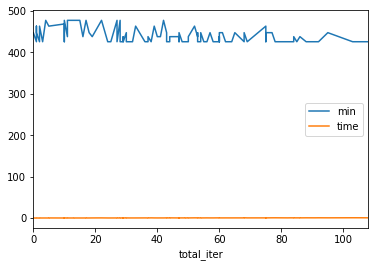

In [616]:
df.plot("total_iter")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x146c4a0f0>]],
      dtype=object)

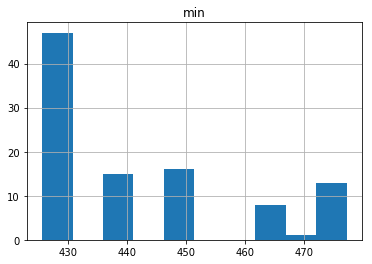

In [617]:
df.hist("min")

### Alternative

In [581]:
df = pd.DataFrame(res_alternative)
df.min(None, "min")
df[df["min"] == min(df["min"])]

,conf,min,time,total_iter
29,"[[3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2]]",2852.572407,0.439666,46


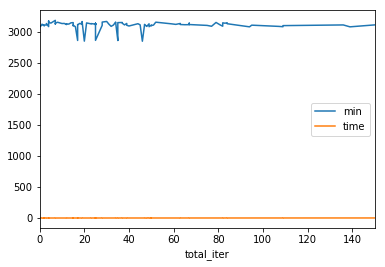

In [582]:
df = df.sort_values("total_iter", ascending=True)
df.plot("total_iter")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1476e9710>]],
      dtype=object)

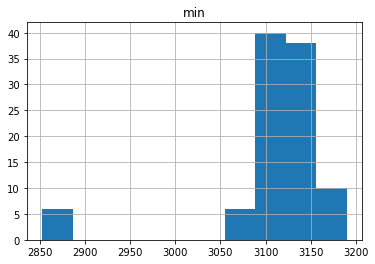

In [583]:
df.hist("min")